<a href="https://colab.research.google.com/github/Jinyong-20/Machine_Learning_Programming/blob/master/lesson6_pets_more.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 6: pets revisited

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'


Mounted at /content/gdrive


\# 드라이브에 마운트, 자동 리로드, 함수 임포트

In [ ]:
bs = 64

\# 배치사이즈 설정

In [ ]:
path = untar_data(URLs.PETS)/'images'

\# 이미지 다운로드 및 경로 설정

## Data augmentation

In [ ]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

\# transform 설정(범위 내에서 변화를 줌, p_는 확률)

In [6]:
doc(get_transforms)

In [ ]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

\# 이미지를 랜덤 비율로 나누어 이미지리스트 생성

In [ ]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

\# 패딩모드를 반사로 설정하여 테두리를 반사하여 표시, 사이즈와 배치 사이즈를 인자로 받아서 이미지 데이터 번치를 생성하여 반환하는 함수 정의

In [9]:
pip install "torch==1.4" "torchvision==0.5.0"

\# 에러 발생을 막기 위한 버전 설치

In [ ]:
data = get_data(224, bs, 'zeros')

\# 이미지데이터번치 생성(제로 패딩 : 검은색으로 테두리 표시)

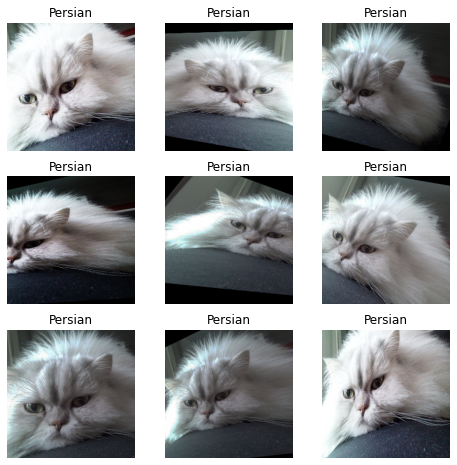

In [11]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

\# 출력

In [ ]:
data = get_data(224,bs)

\# 반사 패딩 적용하여 이미지 데이터 번치 생성

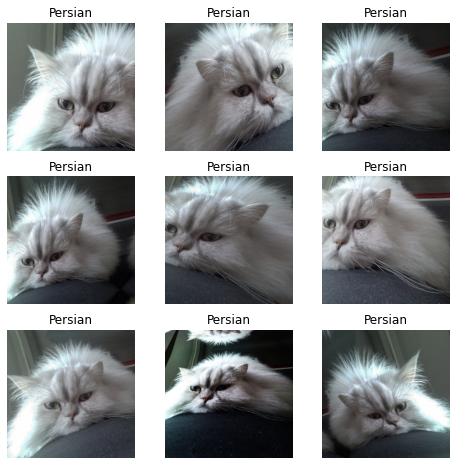

In [13]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [14]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


\# cnn_learner생성

Q : gc.collect()를 시행하는 이유가 뭔가요?

In [15]:
help(gc)

Help on built-in module gc:

NAME
    gc - This module provides access to the garbage collector for reference cycles.

MODULE REFERENCE
    https://docs.python.org/3.6/library/gc
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

DESCRIPTION
    enable() -- Enable automatic garbage collection.
    disable() -- Disable automatic garbage collection.
    isenabled() -- Returns true if automatic collection is enabled.
    collect() -- Do a full collection right now.
    get_count() -- Return the current collection counts.
    get_stats() -- Return list of dictionaries containing per-generation stats.
    set_debug() -- Set debugging flags.
    get_debug() -- Get debugging flags.
    set_threshold() -- Set the collection

In [16]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.634881,0.360315,0.093369,01:27
1,0.977455,0.285369,0.085927,01:21
2,0.701355,0.243435,0.072395,01:21


In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.577761,0.235388,0.065629,01:21
1,0.546179,0.231165,0.062246,01:22


In [ ]:
data = get_data(352,bs)
learn.data = data

In [19]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.514077,0.208651,0.049391,02:21
1,0.482270,0.203568,0.050744,02:22


In [ ]:
learn.save('352')

\# 학습 수행 및 사이즈 변경 후 학습 수행

## Convolution kernel

In [ ]:
data = get_data(352,16)

\# 배치사이즈를 16으로

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

\# 학습결과를 로드해서 러너 생성

Category great_pyrenees

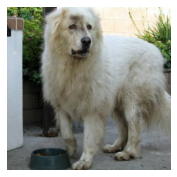

In [23]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

\# 첫번째 인덱스의 데이터를 출력

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [25]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [26]:
k.shape

torch.Size([1, 3, 3, 3])

\# 채널에 곱해줄 kernel을 생성(expand로 복사하여 3x3)

In [27]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

\# 첫번째 이미지의 데이터를 받아옴

In [28]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [ ]:
edge = F.conv2d(t[None], k)

In [48]:
help(F.conv2d)

Help on built-in function conv2d:

conv2d(...)
    conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor
    
    Applies a 2D convolution over an input image composed of several input
    planes.
    
    See :class:`~torch.nn.Conv2d` for details and output shape.
    
    .. include:: cudnn_deterministic.rst
    
    Args:
        input: input tensor of shape :math:`(\text{minibatch} , \text{in\_channels} , iH , iW)`
        weight: filters of shape :math:`(\text{out\_channels} , \frac{\text{in\_channels}}{\text{groups}} , kH , kW)`
        bias: optional bias tensor of shape :math:`(\text{out\_channels})`. Default: ``None``
        stride: the stride of the convolving kernel. Can be a single number or a
          tuple `(sH, sW)`. Default: 1
        padding: implicit paddings on both sides of the input. Can be a
          single number or a tuple `(padH, padW)`. Default: 0
        dilation: the spacing between kernel elements. Can be a single number o

\# 이미지에 컨볼루션을 적용

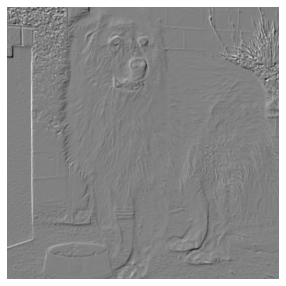

In [30]:
show_image(edge[0], figsize=(5,5));

\# 결과 출력

In [31]:
data.c

37

\# 클래스 갯수, 최종 목표치

In [32]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

\# (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) -> 3개의 입력 채널, 64개의 출력 채널, 간격은 2, kernel 크기는 7x7

In [33]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

\# Conv2d의 최종값은 512x11x11

## Heatmap

In [ ]:
m = learn.model.eval();

\# 러너 모델의 sequential항목, m[0]=Conv2d

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

\# 하나의 이미지 데이터를 추출하여 작은 데이터 배치로 생성, 이를 cuda를 통해 gpu에 전달

In [ ]:
from fastai.callbacks.hooks import *

In [49]:
help(hook_output)

Help on function hook_output in module fastai.callbacks.hooks:

hook_output(module:torch.nn.modules.module.Module, detach:bool=True, grad:bool=False) -> fastai.callbacks.hooks.Hook
    Return a `Hook` that stores activations of `module` in `self.stored`



In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

\# 고리를 반환하는 함수 정의

고리는 원하는 임의의 코드의 출력을 연결하고 저장하는 역할을 수행한다.
연결양이 늘어나는 것을 막기 위해 with으로 고리를 후에 제거한다.

계산 이전의 값을 저장

Q : 코드의 정확한 의미를 모르겠습니다.

In [ ]:
hook_a,hook_g = hooked_backward()

\# 고리 생성

In [39]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

\# 활성화 변수 (512x11x11)

In [40]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

\# 활성화의 평균(512개의 11x11)

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

\# 히트맵을 보여주는 함수 정의(extent로 이미지 확장)

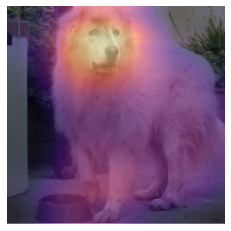

In [42]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

\# 이부분을 잘 모르겠습니다 ㅠ

In [43]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

*grad은 hook_g 첫이미지고 grad_chan [0][0] mean 계산*

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

*mult은 hook_a 첫이미지 * grad_chan (=512) -> mean*

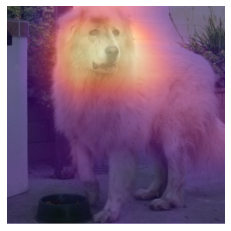

In [45]:
show_heatmap(mult)

In [53]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_187.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_177.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_1.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_96.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_24.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_18.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_99.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_43.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_151.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_158.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_215.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_198.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Sho

In [ ]:
fn = '/content/munchkin.jpg' #Replace with your own image

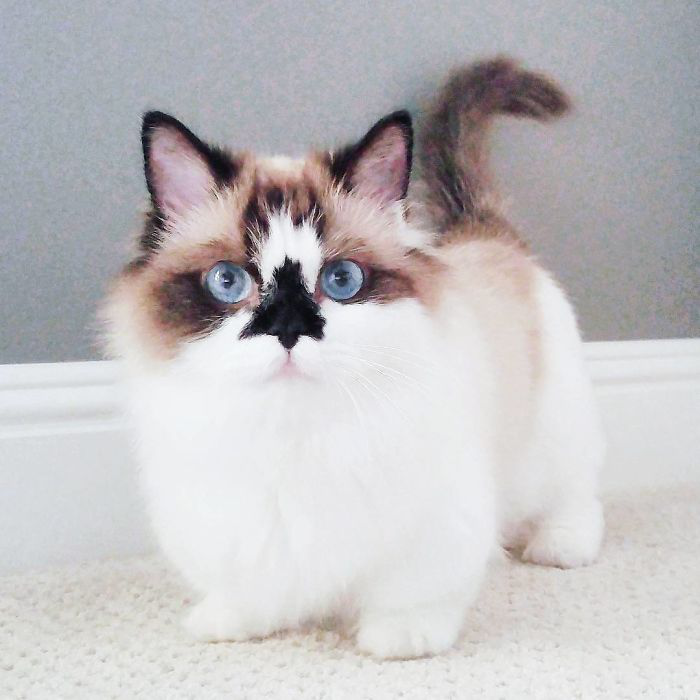

In [69]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

*위 이미지 hooked_backward 함수로 진행*

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

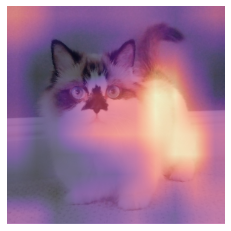

In [73]:
show_heatmap(mult)

\# 위의 과정을 이미지 하나를 정해서 수행

In [74]:
data.classes[0]

'Abyssinian'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

Q : 위와 동일한 코드인데 차이가 생긴 이유가 뭔지 모르겠어요

*다시 계산해서 차이가 생김. 위에 코드 더 자세하게 코멘트 하면 이해될 것임*

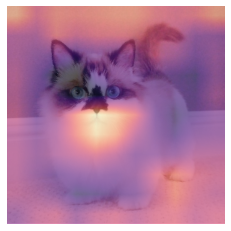

In [77]:
show_heatmap(mult)

## fin